In [2]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

tf.get_logger().setLevel('ERROR')

In [3]:
class CustomLayerPhaseSpace(tf.keras.layers.Layer):
    def __init__(self):
        super(CustomLayerPhaseSpace, self).__init__()
        initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=42)
        
        # Initialize the weights for the rotations, squeezing, translations, and nonlinear activation
        self.theta1 = self.add_weight(shape=(1,), initializer=initializer, trainable=True)
        self.theta2 = self.add_weight(shape=(1,), initializer=initializer, trainable=True)
        self.r = self.add_weight(shape=(1,), initializer=initializer, trainable=True)
        self.kappa = self.add_weight(shape=(1,), initializer=initializer, trainable=True)
        self.b = self.add_weight(shape=(1,), initializer=initializer, trainable=True)
        
    def call(self, inputs):
        # Unpack x and p components
        x, p = inputs[..., 0], inputs[..., 1]
        
        # Apply the first rotation
        x_rot = x * tf.cos(self.theta1) - p * tf.sin(self.theta1)
        p_rot = x * tf.sin(self.theta1) + p * tf.cos(self.theta1)
        
        # Apply squeezing
        x_squeezed = tf.exp(-self.r) * x_rot
        p_squeezed = tf.exp(self.r) * p_rot
        
        # Apply the second rotation
        x_rot2 = x_squeezed * tf.cos(self.theta2) - p_squeezed * tf.sin(self.theta2)
        p_rot2 = x_squeezed * tf.sin(self.theta2) + p_squeezed * tf.cos(self.theta2)
        
        # Apply translation
        x_translated = x_rot2 + self.b
        p_translated = p_rot2
        
        # Calculate radius for the activation
        radius = tf.sqrt(x_translated**2 + p_translated**2)
        
        # Apply the nonlinear activation
        x_activated = x_translated * tf.cos(self.kappa * radius) - p_translated * tf.sin(self.kappa * radius)
        p_activated = x_translated * tf.sin(self.kappa * radius) + p_translated * tf.cos(self.kappa * radius)
        
        # Stack the transformed components together to return a 2D output
        outputs = tf.stack([x_activated, p_activated], axis=-1)
        return outputs

In [4]:
class TQDMProgressBar(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.progress_bar = tqdm(total=self.epochs, desc=f"Epoch 1/{self.epochs}")
        self.start_time = time.time()  # Start time

    def on_epoch_end(self, epoch, logs=None):
        description = f"Epoch {epoch+1}/{self.epochs}"
        self.progress_bar.set_description(description)
        self.progress_bar.update(1)

    def on_train_end(self, logs=None):
        self.progress_bar.close()
        self.end_time = time.time()  # End time
        self.total_time = self.end_time - self.start_time  # Total computation time
        print(f"Total training time: {self.total_time:.2f} seconds")

In [5]:
def train_classical_models(configs, input_data, target_data):
    trained_models = []
    histories = []
    for num_layers, epochs in configs:
        # Create a new model for each configuration
        layers = [CustomLayerPhaseSpace() for _ in range(num_layers)]
        model = tf.keras.Sequential(layers)

        # When compiling the model, specify the reduction to 'none' to avoid reducing the loss
        model.compile(optimizer='adam', loss='mse')
        print(f'Training model with {num_layers} layers for {epochs} epochs...')
        progress_bar = TQDMProgressBar()
        history = model.fit(input_data, target_data, validation_split=0.10, epochs=epochs, verbose=0, callbacks=[progress_bar])

        # Store the trained model and its history
        histories.append(history)
        trained_models.append(model)

    return trained_models, histories

In [6]:
# Function for plotting results and loss histories
def plot_classical_results(models, histories, configs, x_data, y_data, y_data_noisy):
    # Set up the figure for the fits
    fig, axes = plt.subplots(2, len(models)//2, figsize=(15, 10))
    axes = axes.flatten()
    
    # Plot the fits
    for i, model in enumerate(models):
        predictions = model.predict(input_data_reshaped)
        y_pred_x = predictions[:, 0]  # Extract the x component
        axes[i].scatter(x_data, target_data[:, 0], s=5, label='Noisy Data')
        axes[i].plot(x_data, y_pred_x, label='Fitted Curve', color='r')
        axes[i].plot(x_data, y_data_clean, label='True Curve', color='g')
        axes[i].legend()
        axes[i].set_title(f'Layers: {configs[i][0]}, Epochs: {configs[i][1]}')
    
    plt.tight_layout()
    plt.savefig('fits_classical.png', facecolor ='white')
    
    # Set up the figure for the loss histories
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Evaluate models and collect losses
    losses = [history.history['loss'] for history in histories]

    # Plot loss for varying epochs with num_layers = 6
    for i, loss in enumerate(losses[:len(losses)//2]):
        axes[0].plot(loss, label=f'Epochs: {configs[i][1]}')
    axes[0].set_title(f'Loss for Varying Epochs (Layers = {configs[0][0]})')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('MSE Loss')
    axes[0].legend()
    
    # Plot loss for varying num_layers for epochs = 500
    for i, loss in enumerate(losses[len(losses)//2:]):
        axes[1].plot(loss, label=f'Layers: {configs[i+len(losses)//2][0]}')
    axes[1].set_title(f'Loss for Varying Layers (Epochs = {configs[-1][1]})')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MSE Loss')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('mses_classical.png', facecolor ='white')

    # Plot loss and validation loss for the best model
    config_index = configs.index((50, 500))
    history = histories[config_index]
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(8, 6))
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'Loss and Validation Loss vs Epochs for {configs[config_index][0]} layers')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig('mse_with_val_classical.png', facecolor ='white')

Training model with 50 layers for 100 epochs...


Epoch 100/100: 100%|██████████████████████████| 100/100 [00:41<00:00,  2.41it/s]


Total training time: 41.54 seconds
Training model with 50 layers for 200 epochs...


Epoch 200/200: 100%|██████████████████████████| 200/200 [00:48<00:00,  4.11it/s]


Total training time: 48.60 seconds
Training model with 50 layers for 300 epochs...


Epoch 300/300: 100%|██████████████████████████| 300/300 [00:56<00:00,  5.29it/s]


Total training time: 56.67 seconds
Training model with 10 layers for 500 epochs...


Epoch 500/500: 100%|██████████████████████████| 500/500 [00:23<00:00, 21.52it/s]


Total training time: 23.24 seconds
Training model with 25 layers for 500 epochs...


Epoch 500/500: 100%|██████████████████████████| 500/500 [00:40<00:00, 12.28it/s]


Total training time: 40.73 seconds
Training model with 50 layers for 500 epochs...


Epoch 500/500: 100%|██████████████████████████| 500/500 [01:14<00:00,  6.68it/s]


Total training time: 74.89 seconds
4/4 [==============================] - 2s 5ms/step


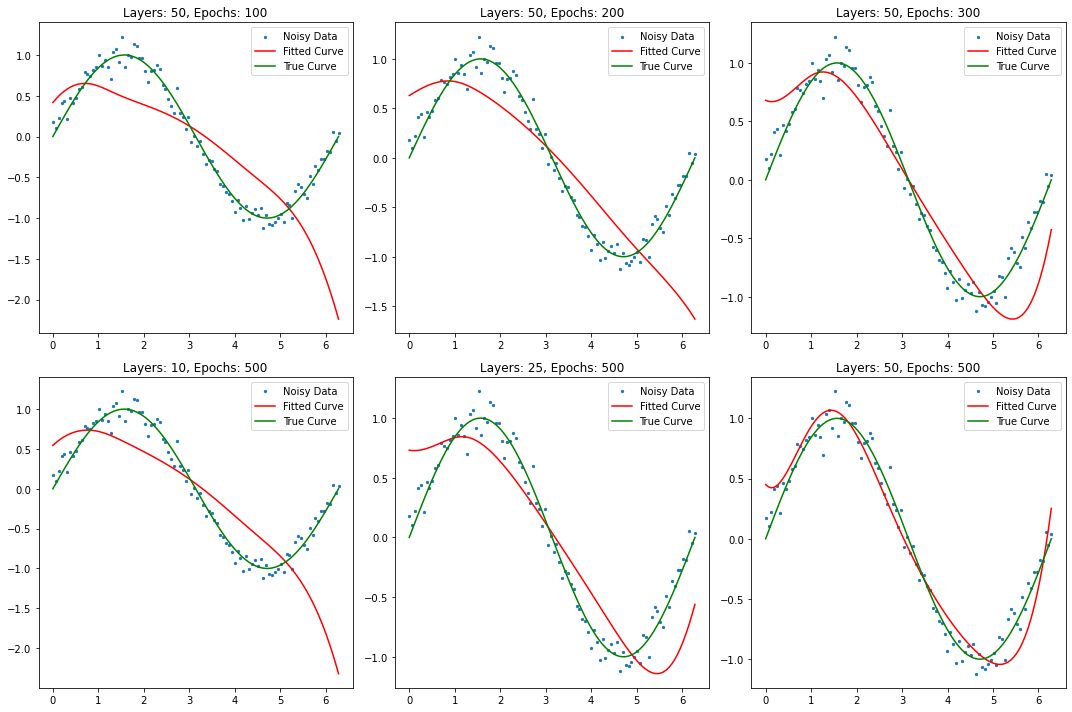

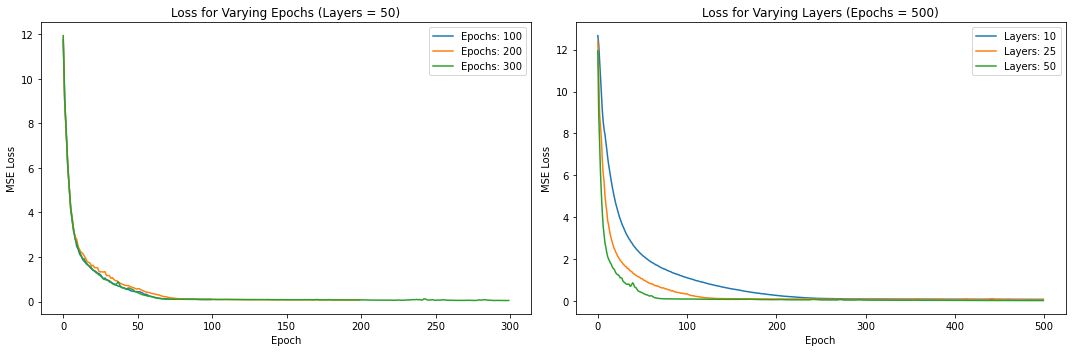

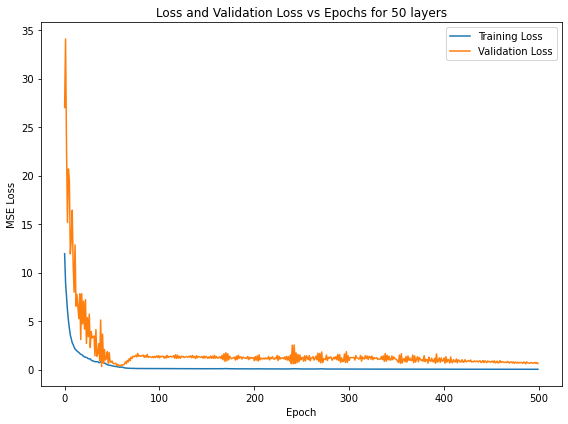

In [7]:
# Generate noisy sine curve data
np.random.seed(0)
n_points = 100

# Generate clean sine wave data and its derivative
x_data = np.linspace(0, 2*np.pi, n_points)
y_data_clean = np.sin(x_data)
y_data_derivative_clean = np.cos(x_data)

# Generate noisy sine wave data and its derivative
y_data_noisy = y_data_clean + np.random.normal(0, 0.1, n_points)
y_data_derivative_noisy = y_data_derivative_clean + np.random.normal(0, 0.1, n_points)

# Prepare the input data by stacking the clean x and p components
input_data = np.stack([x_data, x_data], axis=-1)

# Prepare the target data by stacking the noisy x and p components
target_data = np.stack([y_data_noisy, y_data_derivative_noisy], axis=-1)

# Reshape data to fit the model's input shape
input_data_reshaped = input_data.reshape(-1, 2)
target_data_reshaped = target_data.reshape(-1, 2)

# Evaluate the trained model
configs = [
    (50, 100),
    (50, 200),
    (50, 300),
    (10, 500),
    (25, 500),
    (50, 500)
]

# Train the models with different configurations using the phase space data
trained_models, histories = train_classical_models(configs, input_data_reshaped, target_data_reshaped)

# Plot the results and loss histories using the phase space data
plot_classical_results(trained_models, histories, configs, x_data, y_data_clean, y_data_noisy)